Measure L2500 directly from spectra to see if that helps measurements at all.

In [1]:
#import necessary packages
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from astropy.stats import sigma_clip
import matplotlib.mlab as mlab
import sys
sys.path.append("/Users/Trevor1/Desktop/git/CIV_Distance/") #wherever CIV distance repo is saved
#sys.path.append("/Users/trevormccaffrey/Desktop/git/CIV_Distance/")
from CIVfunctions import project,CIV_distance

#Default MPL colorcycle
mplcol = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def polyfit(x, y, xrange=None):
    xdata = x[~np.isnan(x)&~np.isnan(y)]
    ydata = y[~np.isnan(x)&~np.isnan(y)]
    #perform np.polyfit 
    m, b = np.polyfit(xdata, ydata, 1)
    x = np.arange(min(xdata), max(xdata), (max(xdata)-min(xdata))/5000) if xrange is None else xrange
    y = m*x + b
    return np.array([x,y]).T

def even_fit(xdata, ydata, xrange=None):
    #Fit x vs y, then y vs x, and take the bisection of those two fits
    m1,b1 = np.polyfit(ydata, xdata, 1)
    x1 = np.linspace(ydata.min(),ydata.max(),500)
    y1 = m1*x1 + b1
    
    m2,b2 = np.polyfit(xdata, ydata, 1)
    x2 = np.linspace(xdata.min(),xdata.max(),500)
    y2 = m2*x2 + b2
    
    #Clip before determining scaling
    xdata_clipped = sigma_clip(xdata, sigma=3, maxiters=10, masked=False)
    ydata_clipped = sigma_clip(ydata, sigma=3, maxiters=10, masked=False)
    clip_mask = ((xdata>=xdata_clipped.min()) & (xdata<=xdata_clipped.max())) & ((ydata>=ydata_clipped.min()) & (ydata<=ydata_clipped.max()))
    
    #Format for sklearn scalers
    data = np.array([xdata, ydata]).T
    data_clip = np.array([xdata[clip_mask], ydata[clip_mask]]).T
    fit1 = np.array([y1, x1]).T
    fit2 = np.array([x2, y2]).T
    
    #Fit scaler on clipped data, then transform all data
    scaler = MinMaxScaler().fit(data_clip)
    data_scaled = scaler.transform(data)
    fit1_scale = scaler.transform(fit1)
    fit2_scale = scaler.transform(fit2)
    
    #Get point of intersection for two lines above
    intfit_x_scaled, intfit_y_scaled = line_intersection(fit1_scale, fit2_scale)

    #The slopes of the fits in scaled space
    m1_scale = lin_slope(fit1_scale)
    m2_scale = lin_slope(fit2_scale)

    #Get the slope splitting the angle between slopes in half - see https://www.mathstopia.net/coordinate-geometry/angle-two-lines
    phi = np.arctan((m1_scale-m2_scale)/(1+m1_scale*m2_scale))
    m_new_scaled = (m1_scale-np.tan(phi/2)) / (1+m1_scale*np.tan(phi/2))
    b_new_scaled = intfit_y_scaled - intfit_x_scaled*m_new_scaled
    x_new_scaled = np.linspace(data_scaled[:,0].min(), data_scaled[:,0].max(), 1000) if xrange is None else xrange
    y_new_scaled = m_new_scaled*x_new_scaled + b_new_scaled
    fit_new_scaled = np.array([x_new_scaled, y_new_scaled]).T

    #reverse back into normal coordinates and return fit
    fit_new = scaler.inverse_transform(fit_new_scaled)
    return fit_new

def lin_slope(line):
    #return slope of a linear fit
    return (line[1,1]-line[0,1])/(line[1,0]-line[0,0])

def line_intersection(line1, line2):
    #Get the x-y intersection of two line segments
    
    #Only care about the endpoints
    line1 = ( (line1[0,0], line1[0,1]), (line1[-1,0], line1[-1,1]) )
    line2 = ( (line2[0,0], line2[0,1]), (line2[-1,0], line2[-1,1]) )
    
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y


def project_pt(pt, fit):
    #Get location of a point's orthogonal projection onto a fit
    r2 = (pt[1]-fit[:,1])**2 + (pt[0]-fit[:,0])**2
    return np.array((fit[r2.argmin(),0], fit[r2.argmin(),1]))


def perp_distance(data, xax, yax):
    #Find the distance (with sign) of each point from the yaxis
        
    disty = []
    #distx = []
    #abs_disty = []
    #abs_distx = []
    int_x, int_y = line_intersection(xax, yax) #intersection of the two new axes (the "origin")
    
    for i in range(len(data)):
        r_y = np.sqrt( (data[i,0] - yax[:,0])**2 + (data[i,1] - yax[:,1])**2 ) #dist of point i from y and x axes
        #r_x = np.sqrt( (data[i,0] - xax[:,0])**2 + (data[i,1] - xax[:,1])**2 )
        #abs_disty.append(min(r_y)) ; abs_distx.append(min(r_x))
        
        #Get which side the of the line the point is on 
        proj_x = project_pt(data[i,:], xax) #project data onto new x axis 
        side_y = 1 if (proj_x[0]>=int_x) else -1
        disty.append(side_y*min(r_y))
        
    return np.array(disty)

In [3]:
#Need to work with fits table to read in ugriz array
tbl = Table.read('/Users/Trevor1/Desktop/data/files/VLA2018b/grdr7.8403col.Rankine20match_deredugriz.fits', format='fits')
ugriz_all = np.array(tbl["UGRIZ_DERED"])

In [4]:
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
dat = tbl[names].to_pandas()
#dat = pd.read_csv("/Users/Trevor1/Desktop/data/files/VLA2018b/grdr7.8403col.Rankine20match.csv")

print("Original Data: %d objects" % dat.shape[0])
dat.head()

Original Data: 7602 objects


col1_1                 SDSS_NAME       RA_1a     Dec_1a    z_paul  good  \
0    3903  b"b'074910.94+474944.3'"  117.295606  47.828994  1.922296  True   
1    3905  b"b'075437.85+422115.2'"  118.657721  42.354244  1.961742  True   
2    3951  b"b'082102.05+400748.4'"  125.258553  40.130126  1.935576  True   
3    4020  b"b'085710.90+024329.0'"  134.295457   2.724735  1.951751  True   
4    4051  b"b'112506.96-001647.6'"  171.279009  -0.279891  1.753281  True   

    nBAL    AIi    BIi     CIV_blue  ...        RA_1      DEC_1  Separation_1  \
0  False   True  False  2490.525327  ...  117.295602  47.829007      0.049234   
1  False  False   True  1690.729900  ...  118.657723  42.354256      0.041804   
2  False  False   True  1588.065323  ...  125.258543  40.130115      0.048617   
3  False  False   True   487.859643  ...  134.295460   2.724733      0.010655   
4  False  False   True   -90.998016  ...  171.279004  -0.279894      0.021775   

         RA_2      DEC_2  PLATE  FIBER    MJD      E_BV Separation  
0  117.295601  47.829006   1868     30  53318  0.058504   0.047029  
1  118.657722  42.354256    434     33  51885  0.049930   0.040485  
2  125.258545  40.130116    760     71  52264  0.044532   0.044173  
3  134.295456   2.724733    565    167  52225  0.040639   0.007526  
4  171.279007  -0.279894    281    225  51614  0.029887   0.013693  

[5 rows x 30 columns]

First just visualize the impact each successive cut has

* Remove dust-reddened objects: $\Delta(g-i) < 0.3$ (maybe should be absolute value?)
* Remove RL sources -- safe to consider all FIRST detections as RL (or at least very close to being RL).  In fact we might want to be more robust in removing RL sources at high-$z$ that remain undetected by FIRST.

In [5]:
good   = dat["good"].values
Mi     = dat["MI"].values
del_gi = dat["Delta_G_I"].values
clean  = good & ((Mi<0)&(Mi>-32)&(Mi<-24)) & ((del_gi>-0.3)&(del_gi<0.3))
clean2 = good & ((Mi<0)&(Mi>-32)&(Mi<-24))
d      = 3.08e19 #cm; =10pc
L2500  = -0.4*( Mi + 48.60 + np.log10(1+2) ) + np.log10(4*np.pi*(d**2)) #Eq 4 from Richards+ 2006, QLF paper

blue   = dat["CIV_blue"].values
ew     = dat["CIV_EW"].values
z      = dat["z_paul"].values
logEW  = np.log10(ew)
HeIIEW = dat["HeII_EW"].values
CIVdist= dat["CIV_Distance"].values
first  = dat["FIRST_FLUX"].values!=-1.0
E_BV   = dat["E_BV"].values
plate  = dat["PLATE"].values
fiber  = dat["FIBER"].values
mjd    = dat["MJD"].values

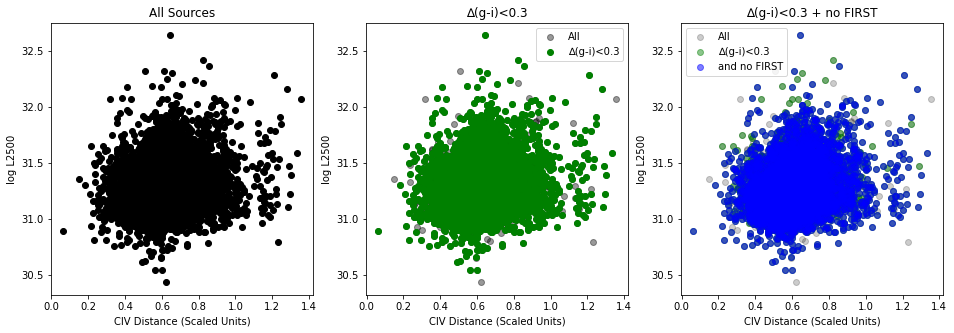

Number of Sources
All:                    7428
∆(g-i)<0.3:             6908
∆(g-i)<0.3 + no FIRST:  6536


In [6]:
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(16,5))

#Plot all objects
ax1.scatter(CIVdist[clean2], L2500[clean2], color="k")
ax1.set_xlabel("CIV Distance (Scaled Units)")
ax1.set_ylabel("log L2500")
ax1.set_title("All Sources")

#Remove dust-reddened sources
ax2.scatter(CIVdist[clean2], L2500[clean2], alpha=0.4, color="k", label="All")
ax2.scatter(CIVdist[clean], L2500[clean], color="g", label="∆(g-i)<0.3")
ax2.set_xlabel("CIV Distance (Scaled Units)")
ax2.set_ylabel("log L2500")
ax2.set_title("∆(g-i)<0.3")
ax2.legend(loc="best")

ax3.scatter(CIVdist[clean2], L2500[clean2], alpha=0.2, color="k", label="All")
ax3.scatter(CIVdist[clean], L2500[clean], alpha=0.45, color="g", label="∆(g-i)<0.3")
ax3.scatter(CIVdist[clean&~first], L2500[clean&~first], alpha=0.5, color="b", label="and no FIRST")
ax3.set_xlabel("CIV Distance (Scaled Units)")
ax3.set_ylabel("log L2500")
ax3.set_title("∆(g-i)<0.3 + no FIRST")
ax3.legend(loc="best")
plt.show()

print("Number of Sources")
print("All:                   %5d" % clean2.sum())
print("∆(g-i)<0.3:            %5d" % clean.sum())
print("∆(g-i)<0.3 + no FIRST: %5d" % (clean&~first).sum())

Cuts definitely make an impact.  Hard to see the full impact from these, but note that there are some clear selection effects in the distribution, i.e., the fraction of low-luminosity sources is inflated by the more sources at lower redshift (see redshift plots below).

In [7]:
#Only keep measurements Amy R counts as "good" - and define our full "clean" sample
dat    = dat[clean&(~first)]

Mi     = dat["MI"].values
d      = 3.08e19 #cm; =10pc
L2500  = -0.4*( Mi + 48.60 + np.log10(1+2) ) + np.log10(4*np.pi*(d**2)) #Eq 4 from Richards+ 2006, QLF paper

del_gi = dat["Delta_G_I"].values
blue   = dat["CIV_blue"].values
ew     = dat["CIV_EW"].values
z      = dat["z_paul"].values
logEW  = np.log10(ew)
HeIIEW = dat["HeII_EW"].values
CIVdist= dat["CIV_Distance"].values
first  = dat["FIRST_FLUX"].values!=-1.0
E_BV   = dat["E_BV"].values
plate  = dat["PLATE"].values
fiber  = dat["FIBER"].values
mjd    = dat["MJD"].values

print("'Clean' Data: %d objects" % dat.shape[0])
dat.head()

'Clean' Data: 6536 objects


col1_1                 SDSS_NAME       RA_1a     Dec_1a    z_paul  good  \
0    3903  b"b'074910.94+474944.3'"  117.295606  47.828994  1.922296  True   
3    4020  b"b'085710.90+024329.0'"  134.295457   2.724735  1.951751  True   
5    4114  b"b'145829.10+323911.2'"  224.621265  32.653135  2.062149  True   
6    4199  b"b'123110.28+335218.5'"  187.792837  33.871813  1.769414  True   
7    4259  b"b'152828.34+002531.7'"  232.118085   0.425499  1.846960  True   

    nBAL    AIi    BIi     CIV_blue  ...        RA_1      DEC_1  Separation_1  \
0  False   True  False  2490.525327  ...  117.295602  47.829007      0.049234   
3  False  False   True   487.859643  ...  134.295460   2.724733      0.010655   
5  False  False   True   620.378983  ...  224.621259  32.653139      0.024135   
6  False  False   True  1154.286407  ...  187.792838  33.871813      0.002193   
7  False  False   True   644.015815  ...  232.118082   0.425498      0.012624   

         RA_2      DEC_2  PLATE  FIBER    MJD      E_BV Separation  
0  117.295601  47.829006   1868     30  53318  0.058504   0.047029  
3  134.295456   2.724733    565    167  52225  0.040639   0.007526  
5  224.621262  32.653137   1648    353  53171  0.016247   0.013982  
6  187.792831  33.871815   2015    103  53819  0.019552   0.019120  
7  232.118088   0.425498    313    596  51673  0.063240   0.008622  

[5 rows x 30 columns]

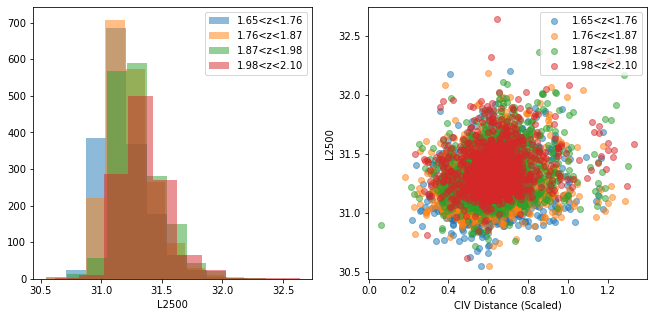

In [8]:
zbins = np.linspace(z.min(), z.max()+.01, 5)
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))
for i in range(len(zbins)-1):
    binmask = (z>=zbins[i])&(z<zbins[i+1])
    ax1.hist(L2500[binmask], alpha=0.5, label="%.2f<z<%.2f" % (zbins[i],zbins[i+1]))
    ax1.set_xlabel("L2500") ; ax1.legend(loc="best")
    ax2.scatter(CIVdist[binmask], L2500[binmask], alpha=0.5, label="%.2f<z<%.2f" % (zbins[i],zbins[i+1]))
    ax2.set_xlabel("CIV Distance (Scaled)") ; ax2.set_ylabel("L2500") ; ax2.legend(loc="best")

Text(0, 0.5, 'L2500')

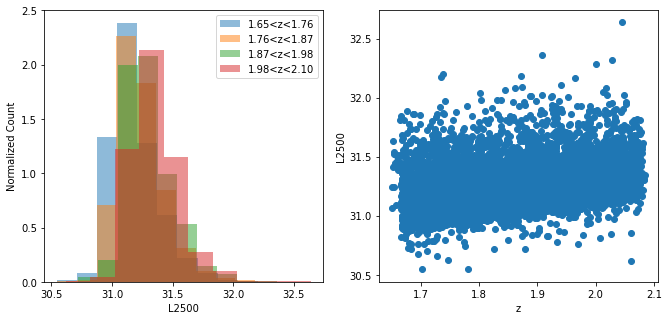

In [9]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))
for i in range(len(zbins)-1):
    binmask = (z>=zbins[i])&(z<zbins[i+1])
    ax1.hist(L2500[binmask], alpha=0.5, label="%.2f<z<%.2f" % (zbins[i],zbins[i+1]), density=True)
    ax1.set_xlabel("L2500") ; ax1.set_ylabel("Normalized Count"); ax1.legend(loc="best")
ax2.scatter(z, L2500)
ax2.set_xlabel("z") ; ax2.set_ylabel("L2500")

See if we can make some better cuts.  Take Gordon's 08/30/21 suggestions - take measurements where L2500 isn't as noisy.
* Can consider redshifts where 2500$Å$ is actually available - $z<3.056$ for DR14 and $z<2.68$ for DR7
* Ignore redshifts where an SDSS filter contains, e.g., both 2500$Å$ and the MgII emission line

We can use the following redshift ranges to avoid the MgII line in 2500Å measurements:
* $1.6 < z < 1.7$
* $2.0 < z < 2.25$
* $2.4 < z < 2.65$

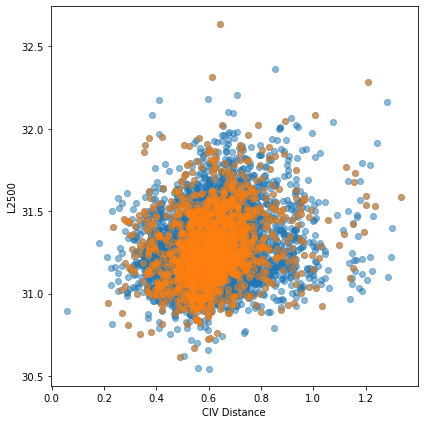

In [10]:
goodz = ((z>=1.6)&(z<=1.7)) | ((z>=2.0)&(z<=2.25)) | ((z>=2.4)&(z<=2.65))
#goodz = ((z>=1.6)&(z<=1.7)) | ((z>=2.0)&(z<=2.25)) | ((z>=2.4)&(z<=3.05))

fig = plt.figure(figsize=(6,6))
plt.scatter(CIVdist, L2500, alpha=0.5)
plt.scatter(CIVdist[goodz], L2500[goodz], alpha=0.5)
plt.ylabel("L2500")
plt.xlabel("CIV Distance")
plt.tight_layout()
plt.savefig("plots/L2500_vs_CIVdist_2500A_noMgII_dr7.png")
plt.show()

In [11]:
print(goodz.sum(), len(dat))

1572 6536


So the MgII line actually does cause a fair bit of noise.  It cuts down the scatter to avoid redshifts where it contributes, but we lose more than half of our objects in the process.  If it's doable, spectral flux measurements will be the way to go.

In [12]:
dat = dat[goodz]

Mi     = dat["MI"].values
d      = 3.08e19 #cm; =10pc
L2500  = -0.4*( Mi + 48.60 + np.log10(1+2) ) + np.log10(4*np.pi*(d**2)) #Eq 4 from Richards+ 2006, QLF paper
del_gi = dat["Delta_G_I"].values
blue   = dat["CIV_blue"].values
ew     = dat["CIV_EW"].values
z      = dat["z_paul"].values
logEW  = np.log10(ew)
HeIIEW = dat["HeII_EW"].values
CIVdist= dat["CIV_Distance"].values
E_BV   = dat["E_BV"].values
plate  = dat["PLATE"].values
fiber  = dat["FIBER"].values
mjd    = dat["MJD"].values

---

Now something we can do instead of taking L2500 measurements from the catalog is measuring directly from the spectra ourselves.  I'll use the autoencoder from ``notebook`` for even more accurate measurements than directly from the spectra.

Load in the spectra

In [13]:
from astropy.io import fits
path = "/Users/Trevor1/Desktop/data/"

In [14]:
#Will want to save homogeneous arrays of each QSO's wavelength, flux, and inverse variance
names   = []
spectra = []
wave    = []
ivar    = []
found   = [] #save dataframe indices which have spectra
BAL_list= []
N = 0

for red, pl, mj, fib in zip(z, plate, mjd, fiber):#, BAL):
    try:
        hdul_spec = fits.open(path+"spectra/VLA_8403col_1.6z2.2/lite/%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        #print(path+"spectra/VLA_8403col_1.6z2.2/lite/%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
        
        
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    
    #Want the same wavelength range for each array
    wavemask   = ((sdss_wave>=1443) & (sdss_wave<=2961))
    sdss_flux  = sdss_flux[wavemask]
    #sdss_flux /= np.median(sdss_flux) #normalize spectrum
    sdss_ivar  = sdss_ivar[wavemask]
    sdss_wave  = sdss_wave[wavemask]
    hdul_spec.close()
    
    if len(sdss_flux) >= 3121:
        #names.append(sdss_name)
        spectra.append(sdss_flux[:3121])
        wave.append(sdss_wave[:3121])
        ivar.append(sdss_ivar[:3121])
        found.append(N)
        #if bal: BAL_list.append(bal)

    N+=1
    if N%250==0: print(N)  
    
spectra = np.array(spectra)
wave    = np.array(wave)
ivar    = np.array(ivar)
found = np.array(found)

250
500
750
1000
1250
1500


In [15]:
found.shape, z.shape

((1530,), (1572,))

In [16]:
z[found]

array([2.062149, 1.674851, 2.037792, ..., 1.67555 , 1.68579 , 2.02845 ])

In [17]:
spectra_normed = spectra / np.nanmedian(spectra, axis=1)[:, np.newaxis]
spectra_normed.shape

(1530, 3121)

In [18]:
import tensorflow as tf
from tensorflow import keras
np.__version__, tf.__version__, keras.__version__

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passi

('1.19.1', '1.12.0', '2.1.6-tf')

In [19]:
#Create the preliminary reconstructions to determine morphing; using reconstructions (mostly) ignores absorption
import tensorflow.keras.backend as K
MASKK= (~((wave[0]>1490)&(wave[0]<1546))).astype(int) #Mask CIV absorption
MASK = K.variable(MASKK)

#Build the autoencoder architecture (keras.models.load_model has all sorts of dependency issues between diff versions of tf)
encoder = keras.models.Sequential([
    keras.layers.Lambda(lambda x: x*MASK, input_shape=[3121]), #this layer is the mask - turn off corresponding neurons
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(6, kernel_initializer="he_normal")
])

decoder = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer="he_normal", input_shape=[6]),
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(3121) #no activation function since we want actual pixel values
])

#Load in the training weights from autoencoder3.ipynb
encoder.load_weights("/Users/Trevor1/Desktop/git/Cosmology_Quasars/autoencoders/models/autoencoder3_enc.h5")
decoder.load_weights("/Users/Trevor1/Desktop/git/Cosmology_Quasars/autoencoders/models/autoencoder3_dec.h5")

ae = keras.models.Sequential([encoder, decoder])

spec_norm_reconst = ae.predict(spectra_normed)

Plot some example reconstructions to show the accuracy of the 2500Å measurements.

In [34]:
(4,3)
(1,2)

(1, 2)

In [35]:
plt.fill_between?

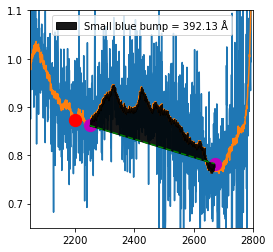

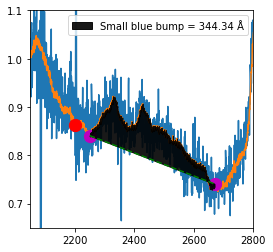

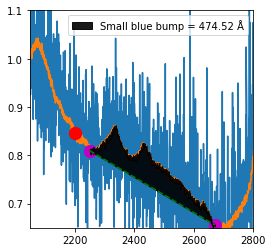

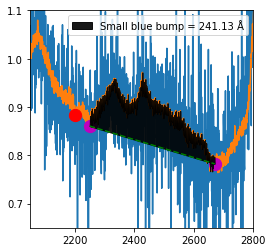

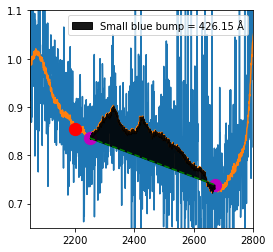

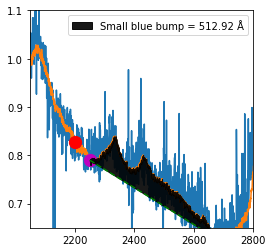

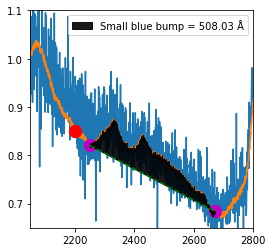

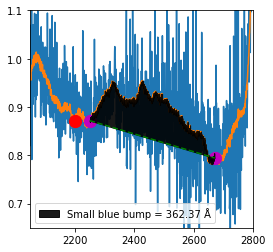

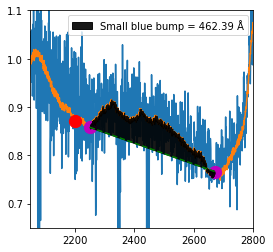

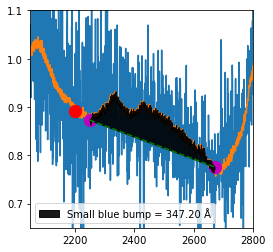

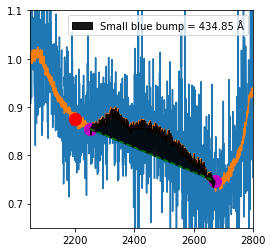

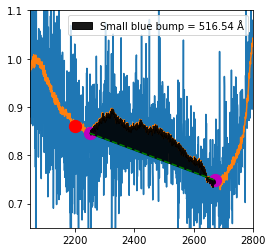

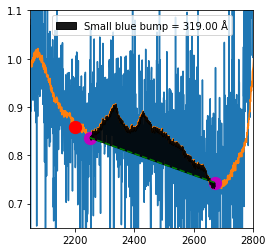

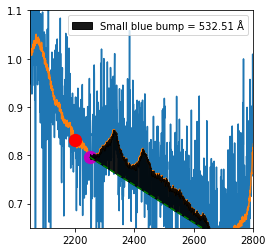

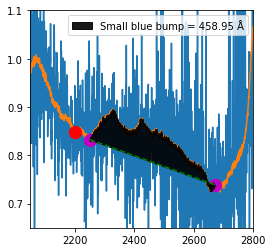

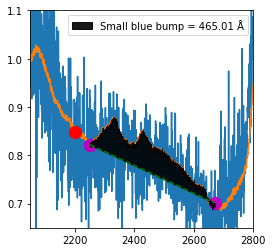

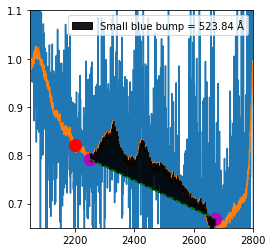

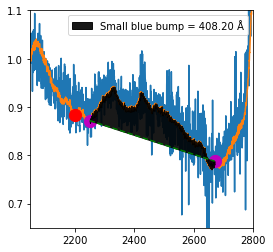

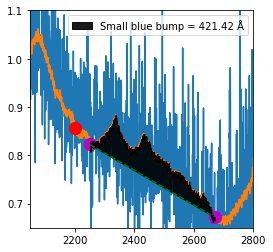

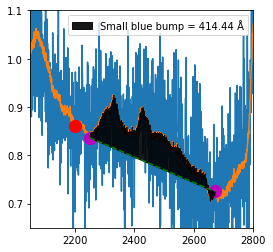

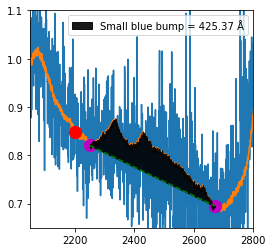

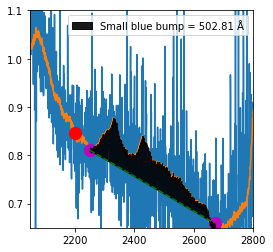

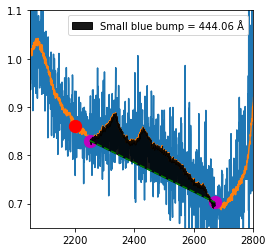

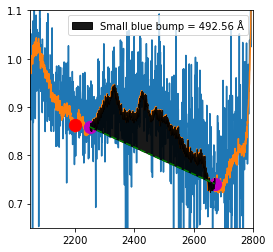

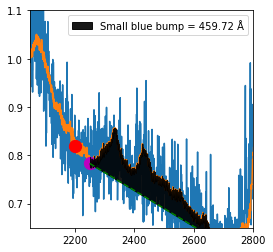

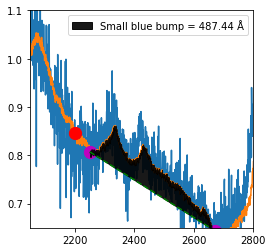

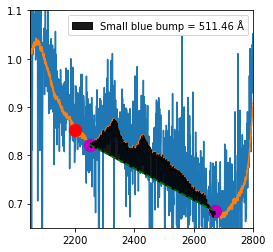

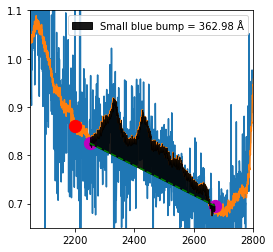

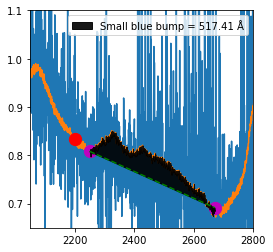

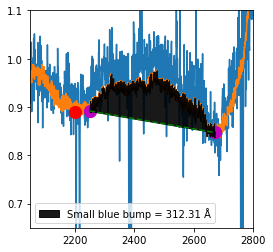

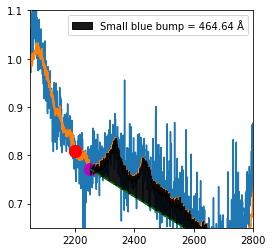

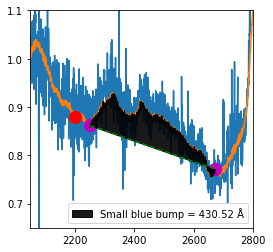

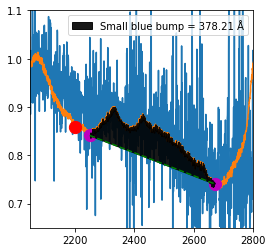

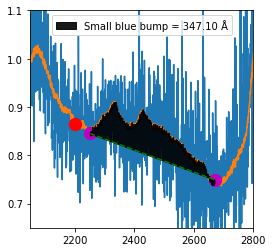

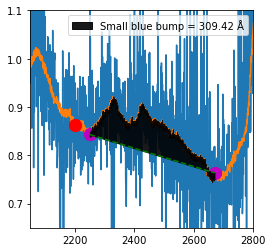

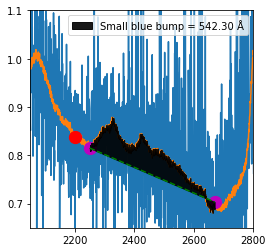

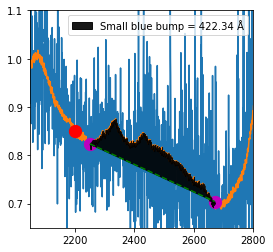

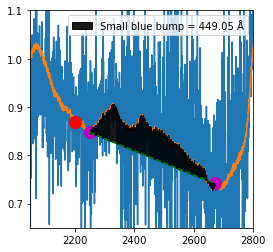

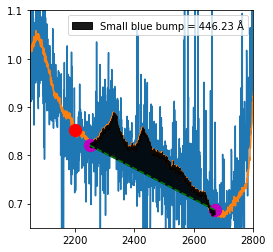

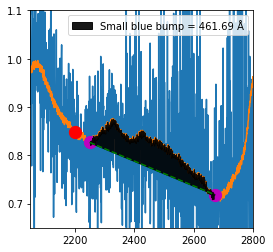

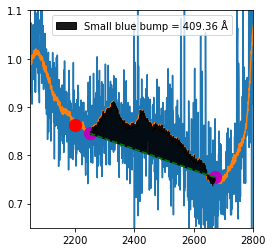

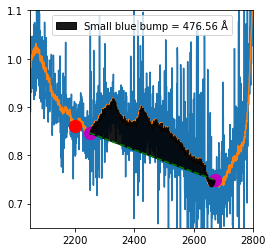

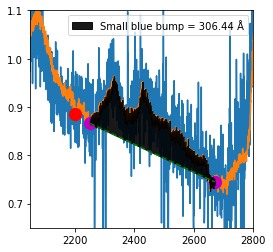

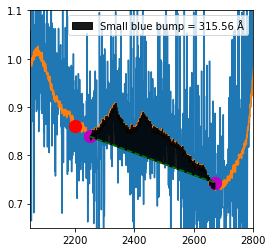

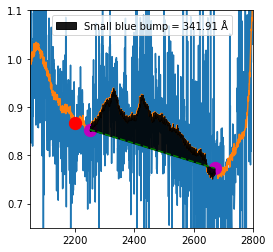

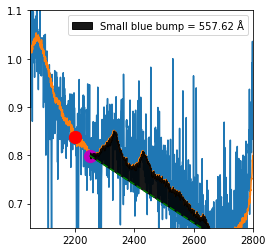

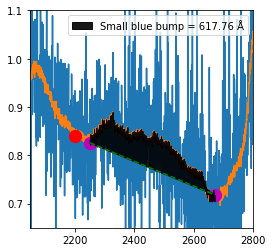

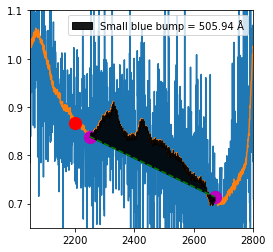

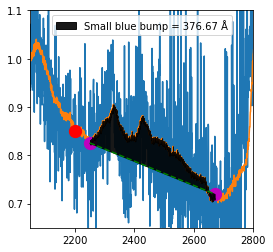

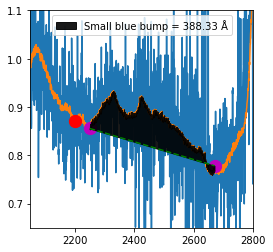

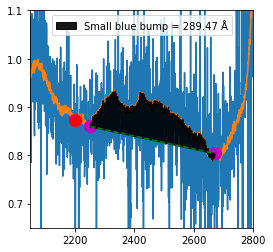

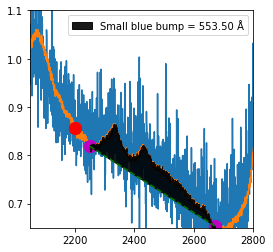

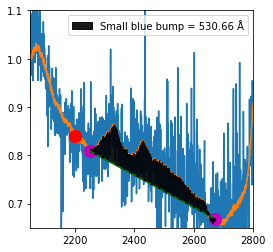

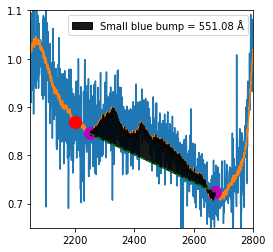

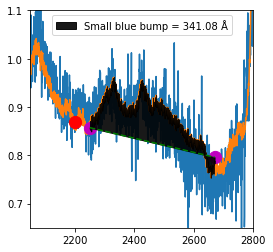

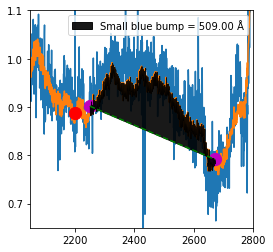

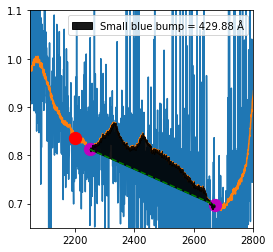

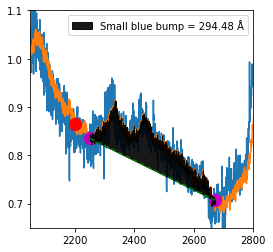

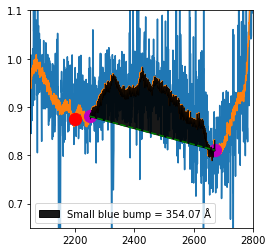

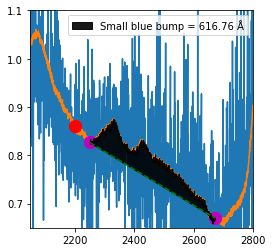

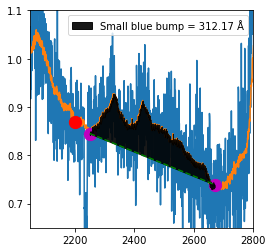

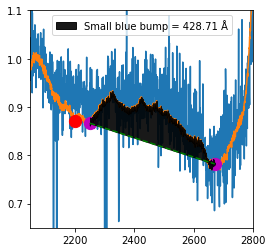

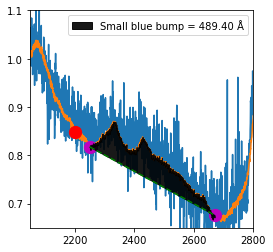

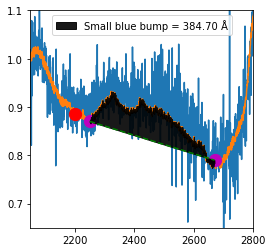

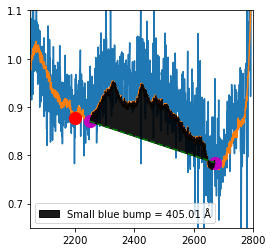

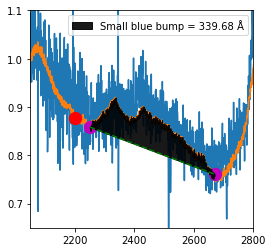

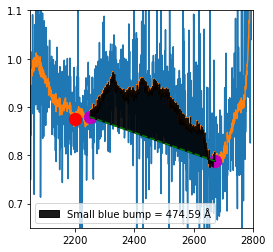

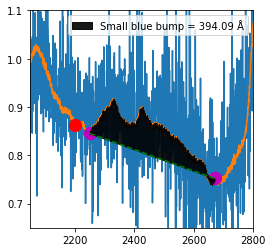

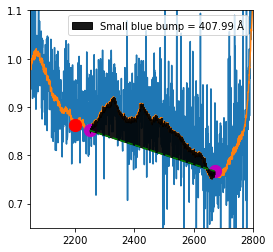

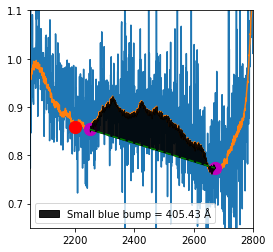

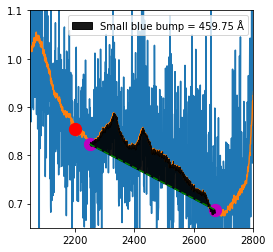

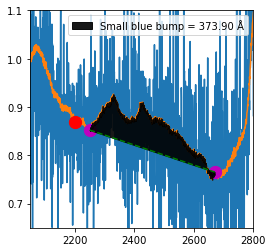

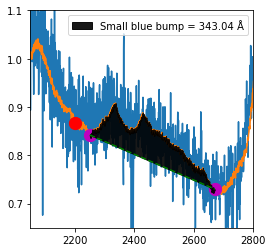

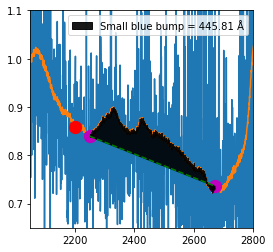

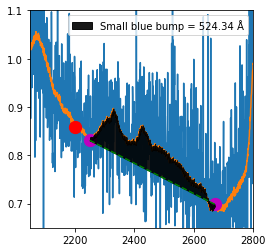

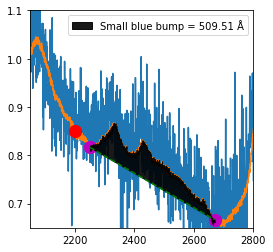

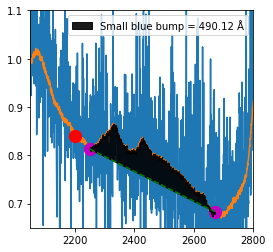

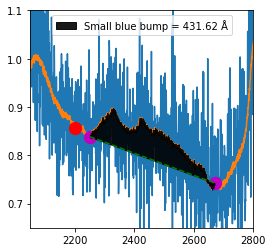

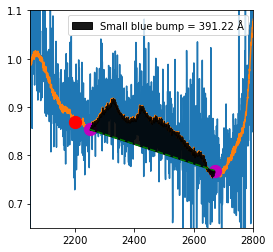

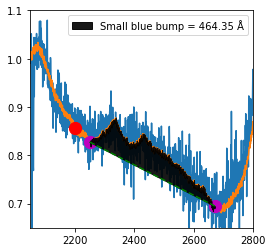

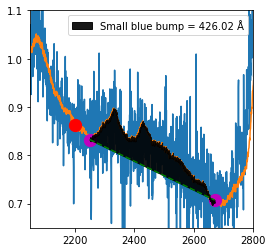

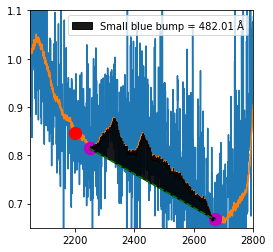

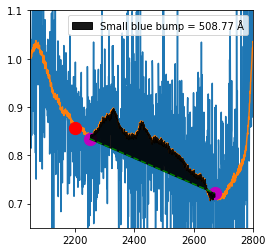

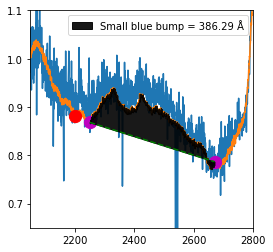

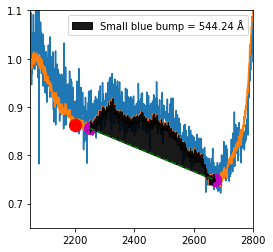

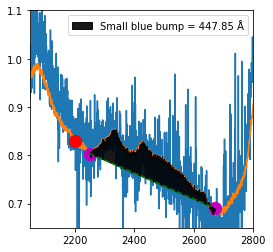

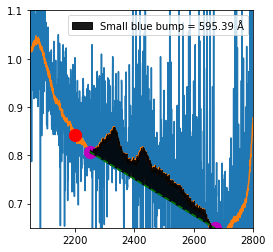

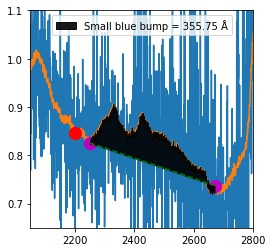

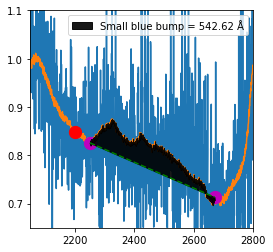

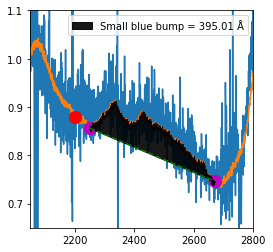

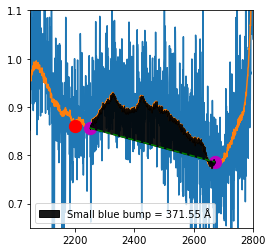

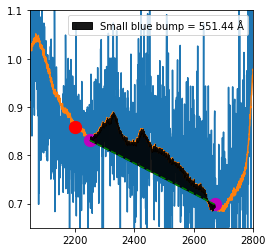

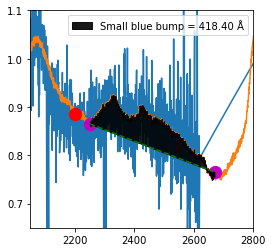

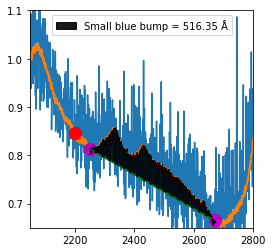

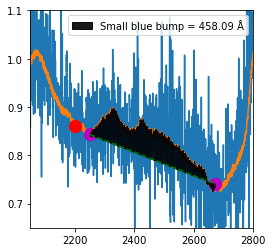

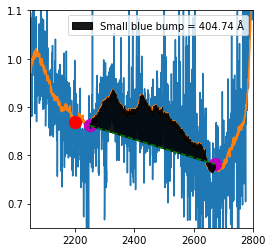

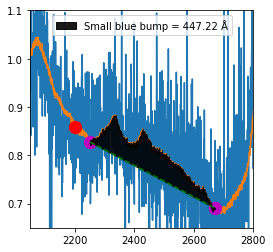

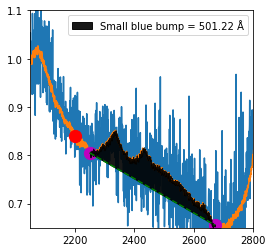

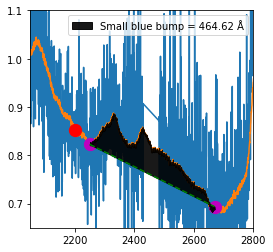

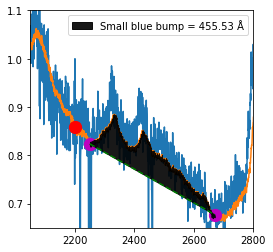

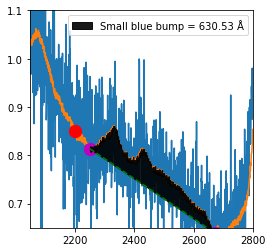

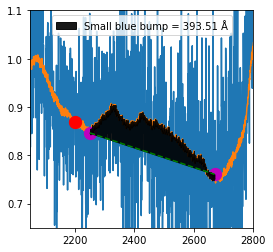

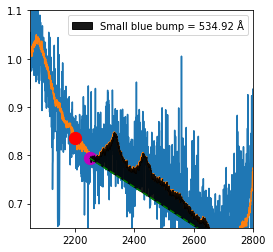

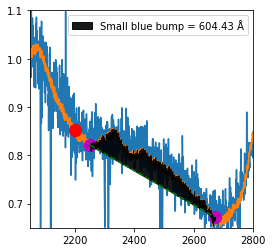

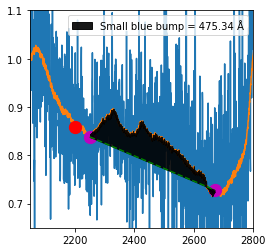

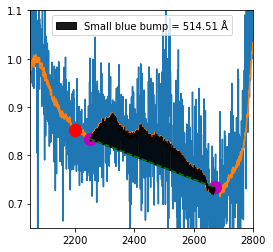

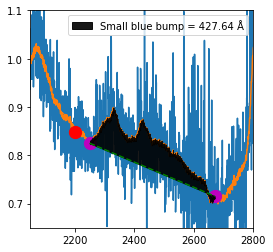

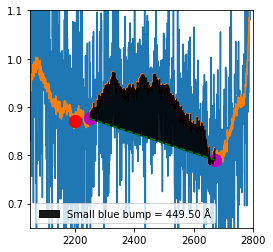

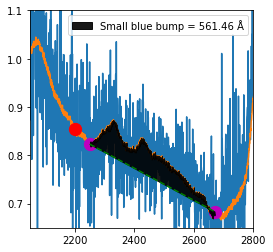

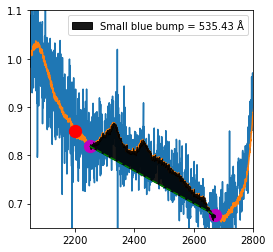

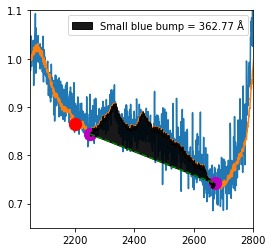

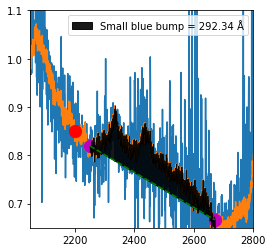

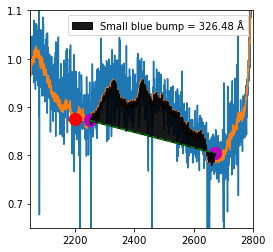

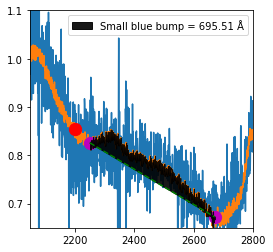

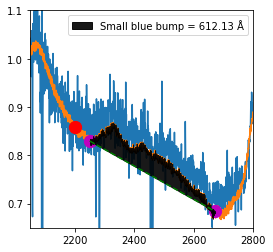

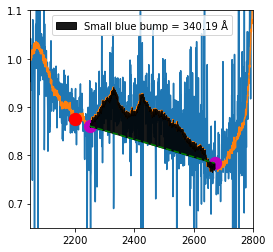

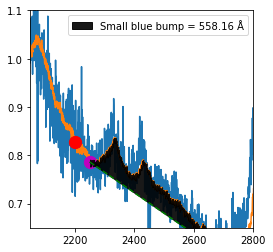

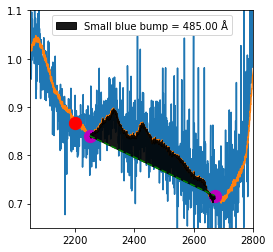

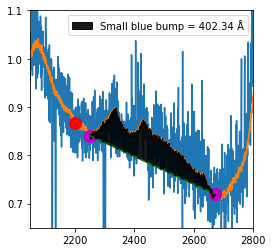

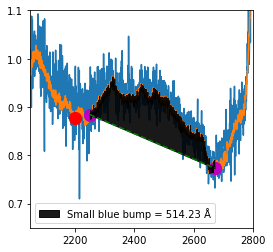

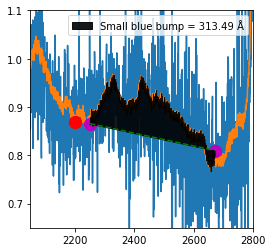

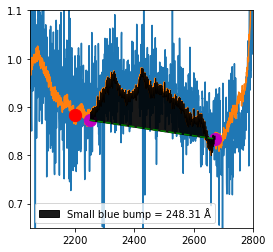

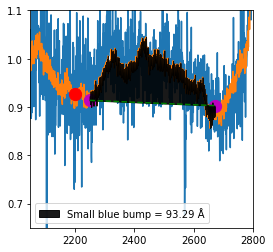

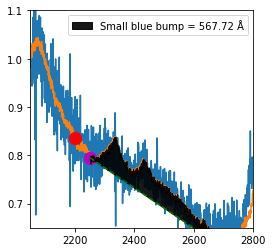

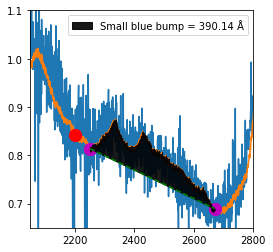

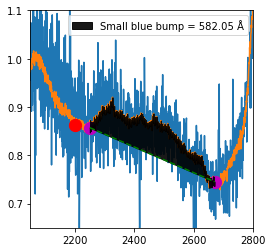

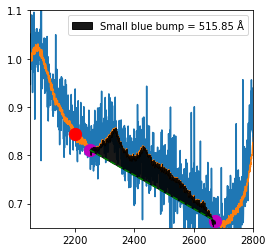

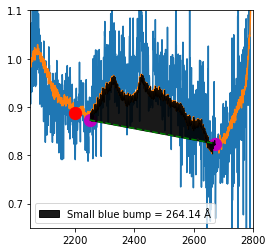

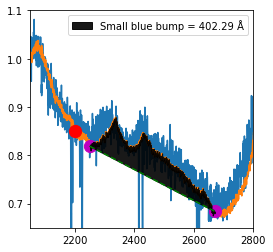

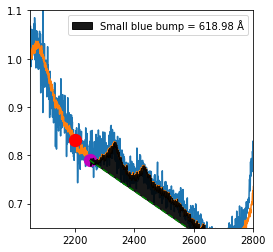

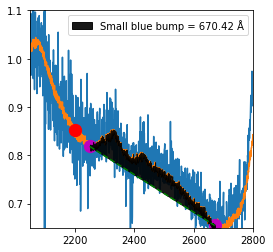

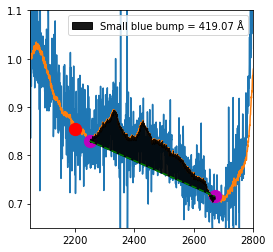

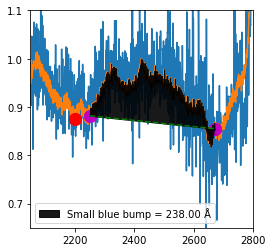

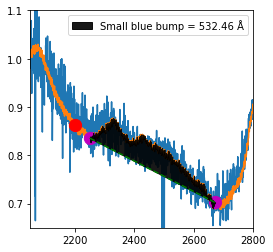

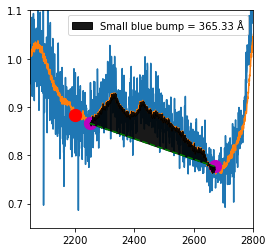

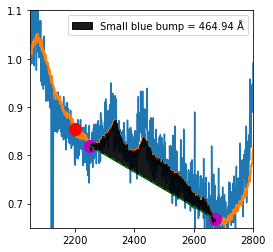

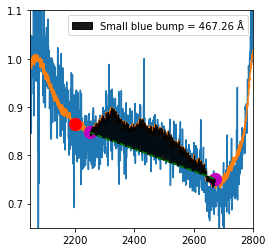

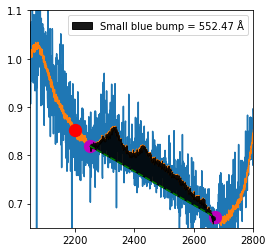

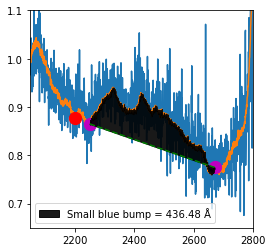

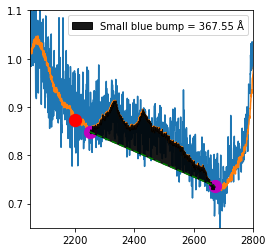

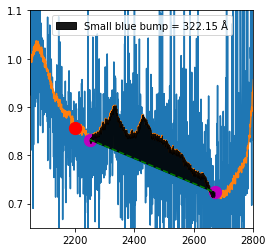

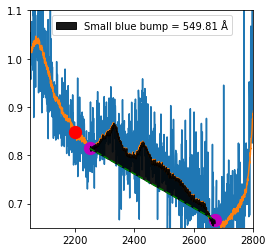

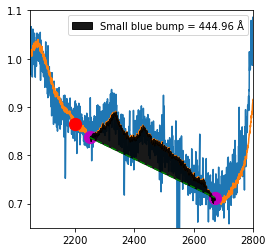

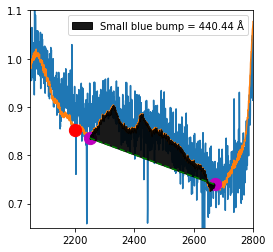

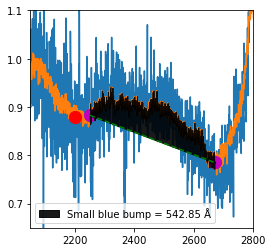

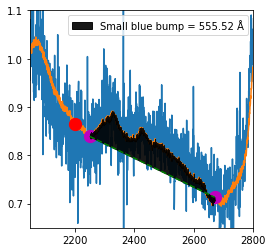

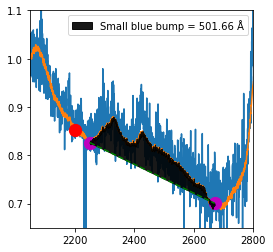

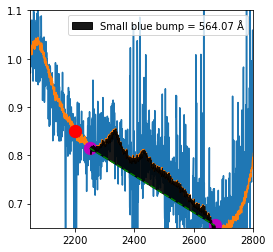

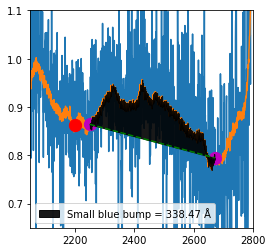

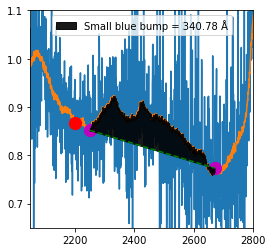

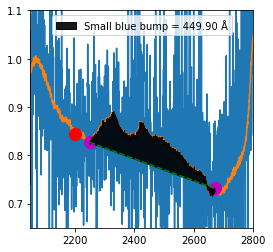

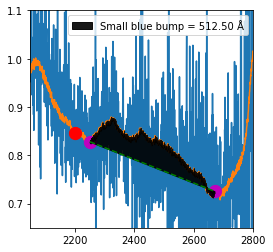

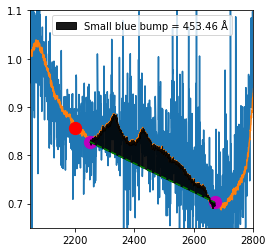

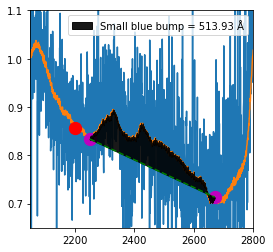

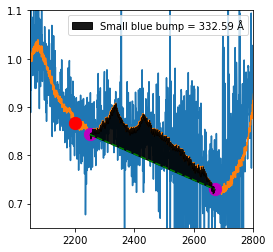

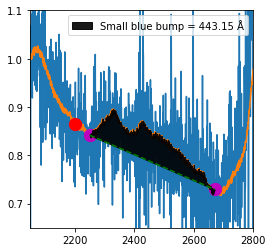

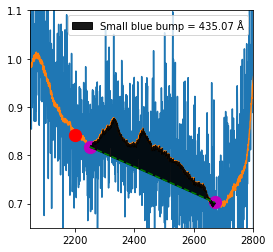

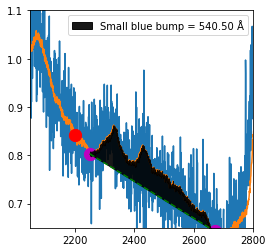

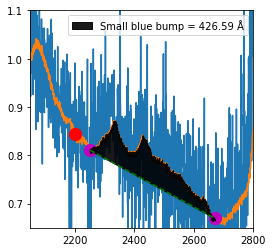

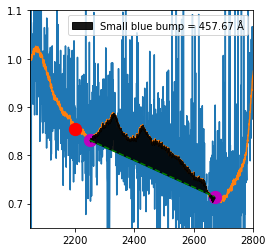

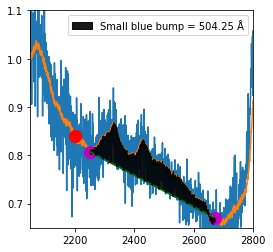

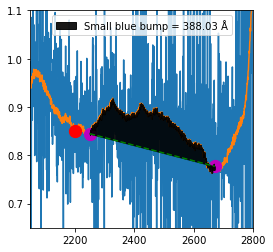

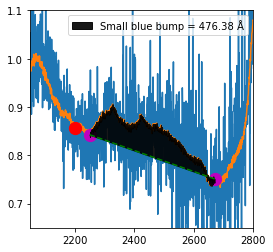

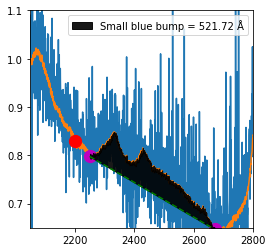

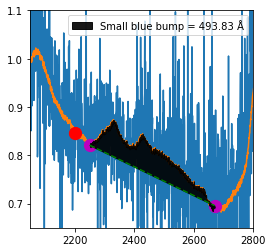

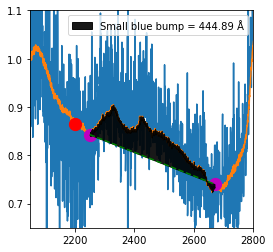

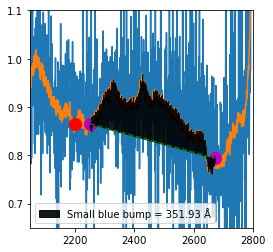

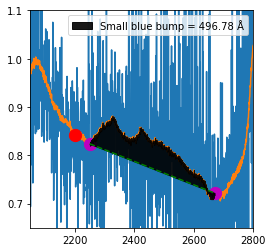

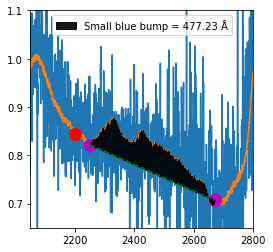

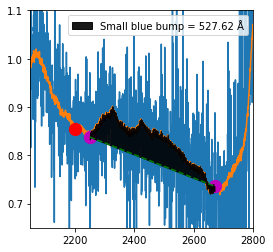

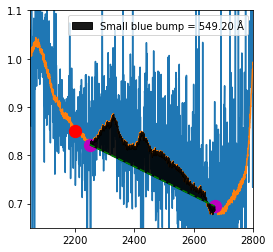

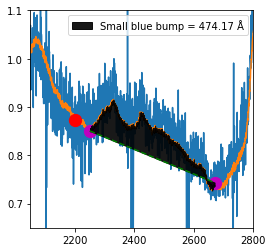

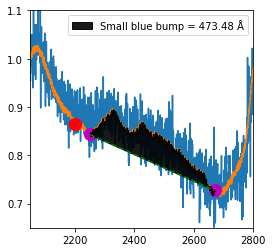

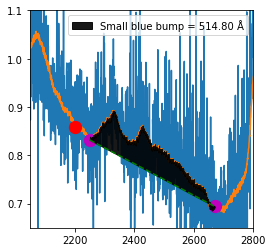

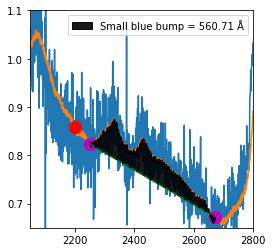

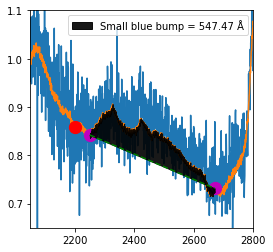

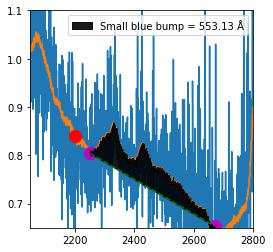

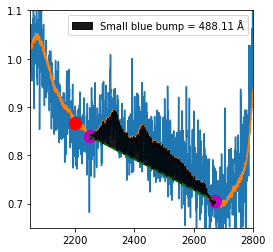

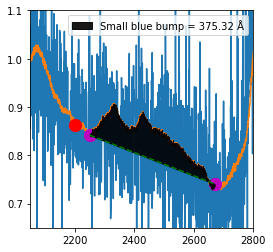

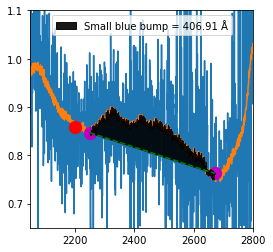

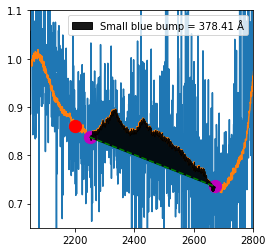

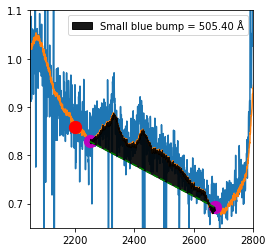

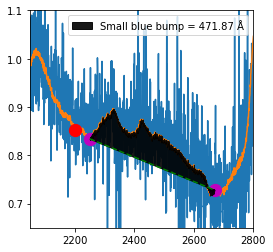

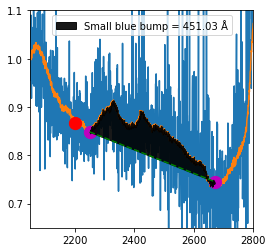

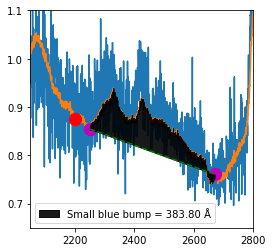

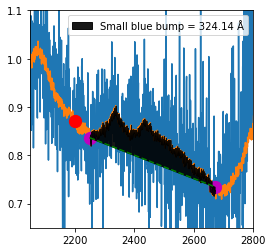

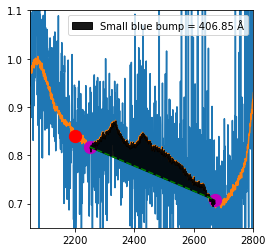

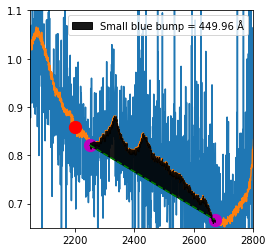

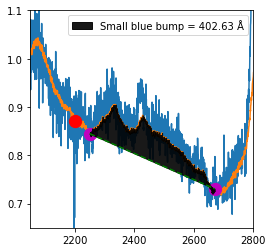

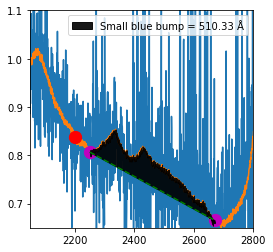

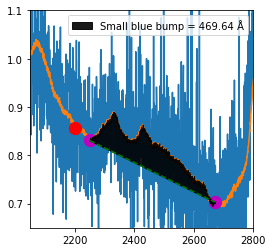

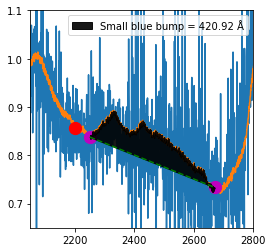

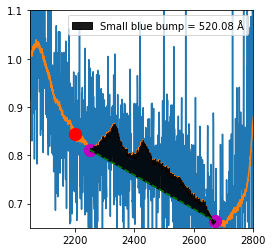

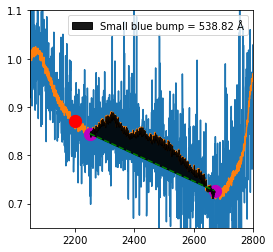

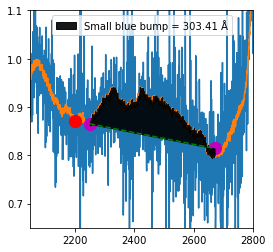

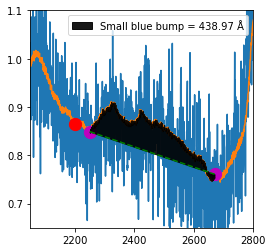

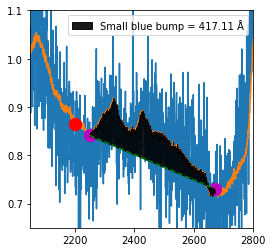

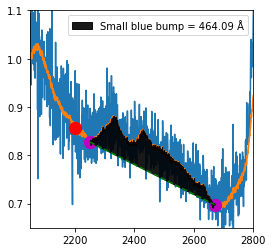

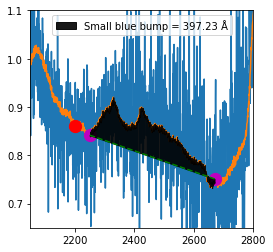

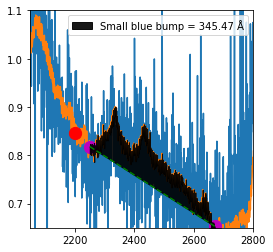

In [65]:
def int_flux(wave, flux, interval):
    EW = 0
    
    #define continuum fit within interval
    arg1, arg2 = np.abs(wave-interval[0]).argmin(), np.abs(wave-interval[1]).argmin()
    m = (flux[arg2]-flux[arg1])/(wave[arg2]-wave[arg1])
    b = flux[arg2] - m*wave[arg2]
    cont_wave = wave[arg1:arg2+1]
    cont_flux = m*cont_wave + b
    bump = flux[arg1:arg2+1] #the small blue bump that we'll be integrating over
    
    #now sum "equivalent width" of bump in this interval
    for i in range(len(cont_wave)-1):
        dlambda = cont_wave[i+1]-cont_wave[i]
        meanflux_i = ( flux[i+1]+flux[i] ) / 2.
        contflux_i = ( cont_flux[i+1]+cont_flux[i] ) / 2.
        EW += ( (meanflux_i-contflux_i) / contflux_i ) * dlambda
    
    return EW, np.array([cont_wave,cont_flux]).T

for i in range(200):
    fig = plt.figure(figsize=(4,4))
    arg2500 = np.abs(wave[i]-2200).argmin()
    arg2250 = np.abs(wave[i]-2250).argmin()
    arg2670 = np.abs(wave[i]-2670).argmin()
    plt.plot(wave[i], spectra_normed[i], zorder=1)
    plt.plot(wave[i], spec_norm_reconst[i], zorder=1)
    plt.scatter(wave[i][arg2500], spec_norm_reconst[i][arg2500], color="r", s=150, zorder=2)
    plt.scatter(wave[i][arg2250], spec_norm_reconst[i][arg2250], color="m", s=150, zorder=2)
    plt.scatter(wave[i][arg2670], spec_norm_reconst[i][arg2670], color="m", s=150, zorder=2)
    plt.xlim(2050,2800)
    plt.ylim(0.65,1.1)
    
    F, continuum = int_flux(wave[i], spec_norm_reconst[i], [2250,2670])
    plt.plot(continuum[:,0], continuum[:,1], "--g")
    plt.fill_between(x=wave[i][arg2250:arg2670], y1=spec_norm_reconst[i][arg2250:arg2670], \
                     y2=continuum[:-1,1], color="k", alpha=0.9, label="Small blue bump = %.2f Å"%F, zorder=2)
    plt.legend(loc="best")
    plt.show()

This is about as accurate as we can hope to get.  Now measure flux for each object and de-normalize.

In [56]:
spec_medians = np.nanmedian(spectra, axis=1) #multiply measured Fnorm by this to get real value
F2500 = []
for i in range(len(spectra)):
    if i in found:
        arg2500 = np.abs(wave[i]-2200).argmin()
        f2500   = spec_norm_reconst[i][arg2500] * (spec_medians[i])
        F2500.append(f2500)
    else:
        F2500.append(np.nan)
        
    if i%250==0: print(i)
F2500 = np.array(F2500)

0
250
500
750
1000
1250
1500


In [66]:
small_bumps = []

for i in range(len(wave)):
    F, _ = int_flux(wave[i], spec_norm_reconst[i], [2250,2670])
    small_bumps.append(F)
small_bumps = np.array(small_bumps)

In [68]:
len(spec_norm_reconst)

1530

In [57]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
DL = 3.086e24*cosmo.luminosity_distance(z).value

Now correct flux at 2500Å for Galactic extinction.

In [58]:
#Galactic extinction correction at 2500Å 
x = 1/(2200./10000.0) 
y = x-1.82 
y2 = y*y 
ax = 1+0.17699*y-0.50447*y2-0.02427*y2*y+0.72085*y2*y2+0.01979*y2*y2*y-0.77530*y2*y2*y2+0.32999*y2*y2*y2*y
bx = 1.41338*y+2.28305*y2+1.07233*y2*y-5.38434*y2*y2-0.62251*y2*y2*y+5.30260*y2*y2*y2-2.09002*y2*y2*y2*y
Alam = 3.1*E_BV*(ax+bx/3.1) 
Alam[x<0]=0 
#flux ratio is 10**(-0.4*-Alam) 
Gcorr = 10**(0.4*Alam) 

F2500[F2500<0]=0.0001 
Fnured = (F2500*1.0e-17)*2200./(2.998e18/2200.) 
Fnu = Gcorr[found]*(F2500*1.0e-17)*2200./(2.998e18/2200.) 

L2500_specred = np.log10(Fnured*4*3.14159*DL[found]*DL[found]*(1+z[found]))
L2500_spec    = np.log10(Fnu*4*3.14159*DL[found]*DL[found]*(1+z[found]))

(array([ 36., 276., 505., 421., 185.,  69.,  24.,   9.,   2.,   1.]),
 array([30.43925194, 30.62506466, 30.81087737, 30.99669009, 31.18250281,
        31.36831552, 31.55412824, 31.73994096, 31.92575367, 32.11156639,
        32.29737911]),
 <BarContainer object of 10 artists>)

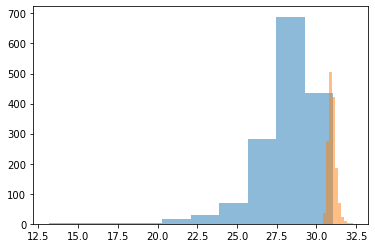

In [59]:
plt.hist(L2500_spec, alpha=0.5)
plt.hist(L2500_specred, alpha=0.5)

(array([ 1.,  0.,  4., 15., 35., 48., 52., 35.,  8.,  2.]),
 array([ 93.29217408, 153.51385579, 213.73553749, 273.9572192 ,
        334.17890091, 394.40058262, 454.62226432, 514.84394603,
        575.06562774, 635.28730945, 695.50899115]),
 <BarContainer object of 10 artists>)

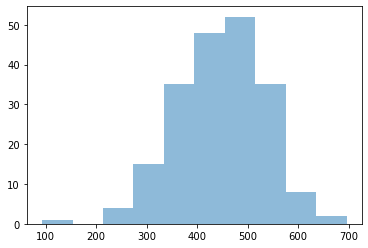

In [60]:
plt.hist(small_bumps, alpha=0.5)

In [69]:
CIVdist.shape, small_bumps.shape

((1572,), (1530,))

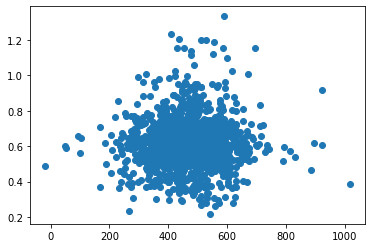

In [71]:
plt.scatter(small_bumps, CIVdist[found])

(array([  3.,   2.,   1.,   3.,  16.,  26.,  66., 268., 663., 480.]),
 array([-45.80754093, -44.0188394 , -42.23013787, -40.44143633,
        -38.6527348 , -36.86403326, -35.07533173, -33.28663019,
        -31.49792866, -29.70922712, -27.92052559]),
 <BarContainer object of 10 artists>)

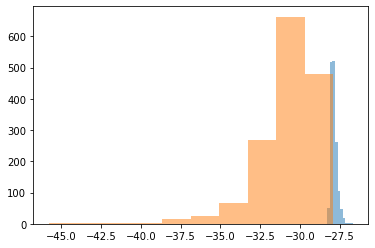

In [72]:
plt.hist(np.log10(Fnured), alpha=0.5)
plt.hist(np.log10(Fnu), alpha=0.5)

(array([  3.,   2.,   2.,   2.,  16.,  29.,  68., 282., 689., 435.]),
 array([13.13379121, 14.92498956, 16.71618791, 18.50738627, 20.29858462,
        22.08978297, 23.88098132, 25.67217967, 27.46337802, 29.25457637,
        31.04577472]),
 <BarContainer object of 10 artists>)

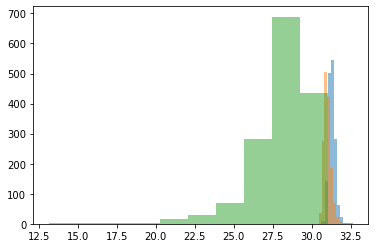

In [73]:
plt.hist(L2500, alpha=0.5)
plt.hist(L2500_specred, alpha=0.5)
plt.hist(L2500_spec, alpha=0.5)

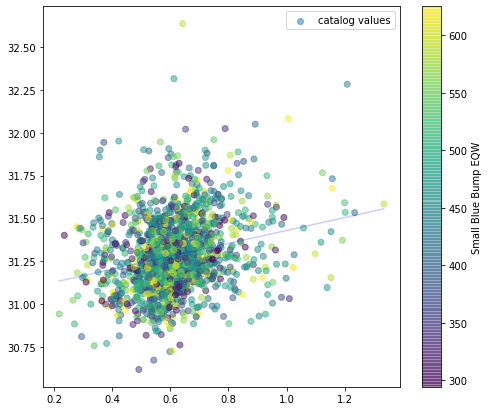

In [79]:
fit1 = polyfit(CIVdist, L2500)
fit2 = polyfit(CIVdist[found], L2500_spec)
fig = plt.figure(figsize=(8,7))
plt.scatter(CIVdist[found], L2500[found], alpha=0.5, label="catalog values", c=small_bumps, vmin=np.percentile(small_bumps,5), vmax=np.percentile(small_bumps,95))
cbar = plt.colorbar()
cbar.ax.set_ylabel("Small Blue Bump EQW")
#plt.scatter(CIVdist[found], L2500_specred, alpha=0.3, label="spectral measurements")
#plt.scatter(CIVdist[found], L2500_spec, alpha=0.6, label="spectral + extinction-corrected")
plt.plot(fit1[:,0], fit1[:,1], "-b", alpha=0.2)
#plt.plot(fit2[:,0], fit2[:,1], "-g", alpha=0.7)
plt.legend(loc="best")
plt.show()

In [28]:
len(dat)

1572

In [82]:
a = np.array([3,1,7])

In [86]:
for i,j in zip( range(4), list(range(3))+[1] ):
    print(i,j)

0 0
1 1
2 2
3 1


In [98]:
a = np.array([3,1,7])
a = np.concatenate((a, np.zeros(0)), axis=0)
a

array([3., 1., 7.])

In [99]:
np.nan*np.zeros(0)

array([], dtype=float64)

In [105]:
a[1:None]

array([1., 7.])

In [106]:
np.unique?